# Deep Learning Term Project for ECG (DIL700)

# Iteration 4

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df = train_df[train_df[187] != 0]
test_df = test_df[test_df[187] != 0]
full_df = full_df[full_df[187] != 0]

train_df.loc[train_df[187] == 1, 187] = 0
test_df.loc[test_df[187] == 1, 187] = 0
full_df.loc[full_df[187] == 1, 187] = 0

train_df.loc[train_df[187] == 2, 187] = 1
test_df.loc[test_df[187] == 2, 187] = 1
full_df.loc[full_df[187] == 2, 187] = 1

train_df.loc[train_df[187] == 4, 187] = 2
test_df.loc[test_df[187] == 4, 187] = 2
full_df.loc[full_df[187] == 4, 187] = 2

In [4]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
72471,1.000000,0.666667,0.100457,0.036530,0.073059,0.050228,0.018265,0.105023,0.132420,0.091324,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
72472,0.983696,1.000000,0.331522,0.000000,0.108696,0.163043,0.130435,0.190217,0.288043,0.222826,...,0.461957,0.483696,0.500000,0.494565,0.510870,0.51087,0.505435,0.472826,0.434783,0.0
72473,1.000000,0.911504,0.216814,0.000000,0.101770,0.199115,0.176991,0.194690,0.252212,0.238938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
72474,0.090498,0.126697,0.217195,0.361991,0.461538,0.556561,0.443439,0.434389,0.452489,0.511312,...,0.122172,0.131222,0.140271,0.158371,0.176471,0.20362,0.212670,0.000000,0.000000,0.0
72475,0.961111,1.000000,0.551852,0.101852,0.040741,0.085185,0.094444,0.088889,0.085185,0.070370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,2.0


In [5]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
18118,1.000000,0.758982,0.473054,0.193114,0.142216,0.176647,0.161677,0.142216,0.121257,0.107784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18119,1.000000,0.746556,0.088154,0.035813,0.212121,0.253444,0.269972,0.283747,0.275482,0.272727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18120,0.972840,0.728395,0.000000,0.037037,0.162963,0.143210,0.123457,0.140741,0.133333,0.096296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18121,1.000000,0.694444,0.238095,0.321429,0.337302,0.337302,0.301587,0.325397,0.325397,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18122,0.939815,0.791667,0.199074,0.000000,0.055556,0.101852,0.106481,0.143519,0.222222,0.189815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [6]:
print(train_df[187].unique())

[0. 1. 2.]


In [7]:
labels = ['Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["S","V","Q"]

In [8]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
# print(labels[3],':', len(train_df[train_df[187]==3]))
# print(labels[4],':', len(train_df[train_df[187]==4]))

Number of samples in data:
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [9]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
# print(labels[3],':', len(test_df[test_df[187]==3]))
# print(labels[4],':', len(test_df[test_df[187]==4]))

Number of samples in data:
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [10]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "S", 1: "V", 2: "Q",})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "S", 1: "V", 2: "Q",})

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "S", 1: "V", 2: "Q",})

In [11]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
86169,1.000000,0.519298,0.547368,0.533333,0.547368,0.501754,0.508772,0.414035,0.294737,0.171930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86086,0.650696,0.554869,0.448223,0.357032,0.244204,0.148377,0.061824,0.015456,0.000000,0.034003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79122,1.000000,1.000000,0.789926,0.383292,0.194103,0.170762,0.160934,0.143735,0.156020,0.162162,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86507,0.718553,0.621069,0.509434,0.389937,0.254717,0.136792,0.059748,0.014151,0.000000,0.018868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75622,0.780458,0.756333,0.523522,0.288299,0.168878,0.078408,0.043426,0.016888,0.002413,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75892,0.914842,0.895377,0.776156,0.608272,0.437956,0.403893,0.374696,0.430657,0.501217,0.335766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79588,0.727447,0.671785,0.531670,0.332054,0.161228,0.051823,0.057582,0.082534,0.143954,0.165067,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81435,1.000000,0.570922,0.578014,0.574468,0.570922,0.560284,0.528369,0.446809,0.336879,0.191489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77017,1.000000,0.890135,0.663677,0.468610,0.374439,0.329596,0.316143,0.311659,0.278027,0.239910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
y_train

86169    2.0
86086    2.0
79122    1.0
86507    2.0
75622    1.0
        ... 
75892    1.0
79588    1.0
81435    2.0
77017    1.0
85531    2.0
Name: 187, Length: 11553, dtype: float64

In [13]:
y_train_nn

,S,V,Q
86169,0,0,1
86086,0,0,1
79122,0,1,0
86507,0,0,1
75622,0,1,0
...,...,...,...
75892,0,1,0
79588,0,1,0
81435,0,0,1
77017,0,1,0


In [14]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
86744,0.508380,0.432961,0.379888,0.379888,0.326816,0.290503,0.245810,0.189944,0.086592,0.022346,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
77279,0.986207,1.000000,0.957471,0.898851,0.903448,0.855172,0.739080,0.536782,0.311494,0.282759,...,0.287356,0.293103,0.290805,0.287356,0.293103,0.302299,0.297701,0.296552,0.0,0.0
76686,0.797271,0.881092,0.844055,0.805068,0.766082,0.752437,0.771930,0.727096,0.522417,0.337232,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
87327,0.904387,0.859393,0.799775,0.757030,0.680540,0.598425,0.496063,0.400450,0.303712,0.256468,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
82046,0.931507,0.864384,0.802740,0.724658,0.658904,0.573973,0.446575,0.308219,0.202740,0.152055,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87166,0.971623,0.921680,0.861521,0.801362,0.733258,0.620885,0.502838,0.399546,0.332577,0.283768,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
74346,1.000000,0.528517,0.406844,0.357414,0.262357,0.254753,0.209125,0.167300,0.148289,0.174905,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
72571,0.576471,0.541176,0.427451,0.415686,0.443137,0.470588,0.435294,0.309804,0.176471,0.113725,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
84747,0.607990,0.536829,0.444444,0.357054,0.243446,0.146067,0.077403,0.034956,0.000000,0.009988,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


## Dataset Distribution

### Training set

In [15]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    2223
1    5788
2    6431
Name: 187, dtype: int64


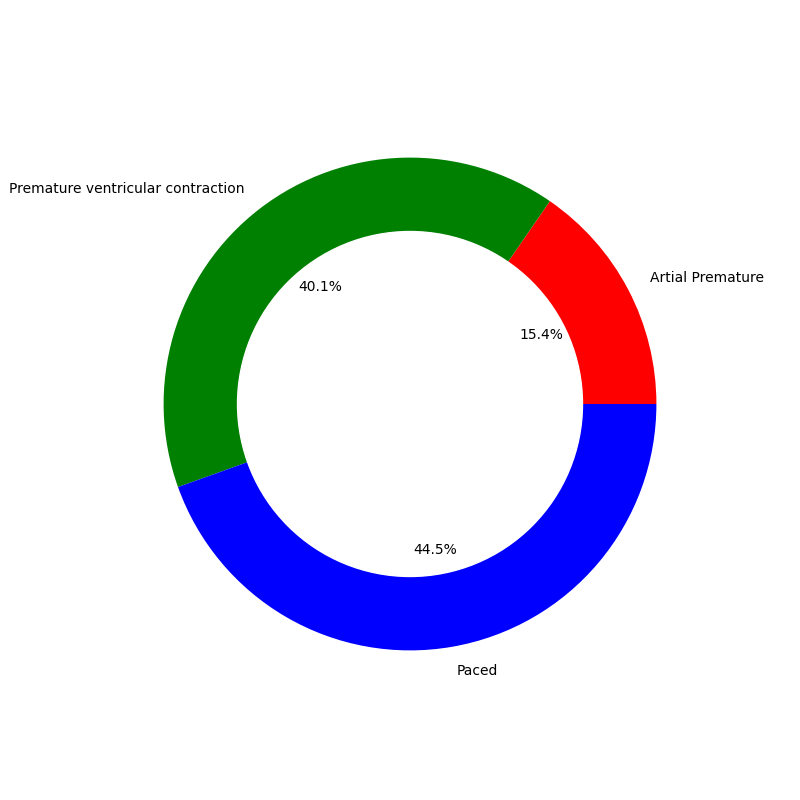

In [16]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [17]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0     556
1    1448
2    1608
Name: 187, dtype: int64


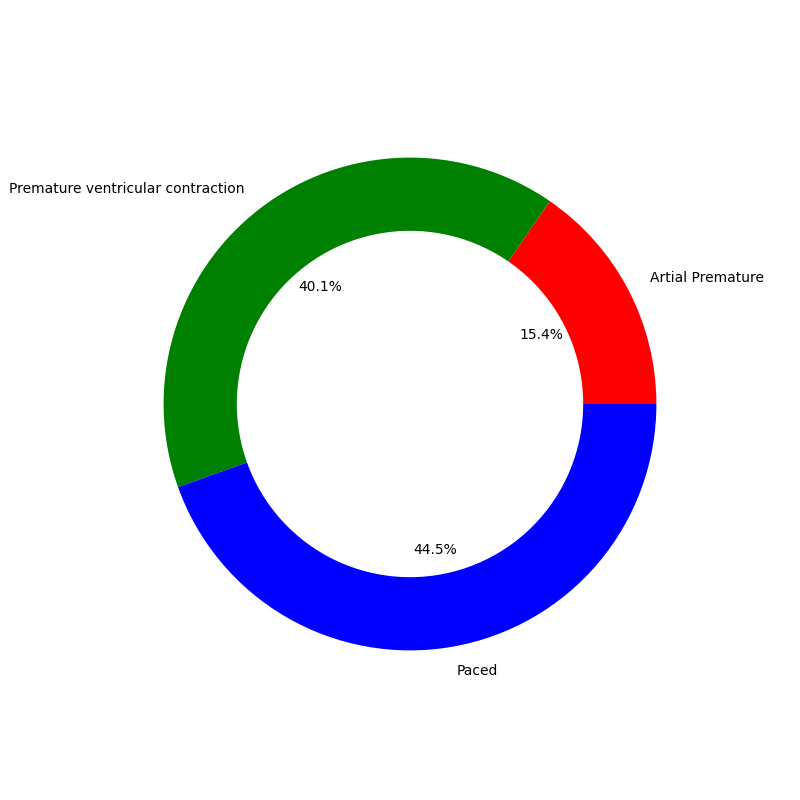

In [18]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Simple ANN

Update weights of loss function for unbalanced dataset

In [19]:
import keras.backend as K
from keras.losses import categorical_crossentropy
def weighted_categorical_crossentropy(weights):
    """ A weighted version of categorical cross-entropy loss function for four classes. 
    :param weights: a list of weights for each class, in the order of class indices
    """
    weights = K.variable(weights)
    def loss(y_true, y_pred, weights=weights):
        # cast weights and y_true to the same data type as y_pred        
        y_true = K.cast(y_true, y_pred.dtype)
        weights = K.cast(weights, y_pred.dtype)
        # scale predictions so that the class probabilities of each sample sum to 1        
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip predictions to avoid numerical instability        
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calculate weighted cross entropy        
        loss = -K.mean(K.sum(weights * y_true * K.log(y_pred), axis=-1))
        return loss
    return loss

In [20]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])


model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))
model_ann.load_weights('best_ann_5.h5')
#save_model(model_ann, 'Simple_ANN_MITBIH', 'keras')

Epoch 1/40
362/362 [==============================] - 2s 4ms/step - loss: 0.2717 - accuracy: 0.8961 - val_loss: 0.1705 - val_accuracy: 0.9380
Epoch 2/40
362/362 [==============================] - 1s 3ms/step - loss: 0.1263 - accuracy: 0.9559 - val_loss: 0.1117 - val_accuracy: 0.9664
Epoch 3/40
362/362 [==============================] - 1s 3ms/step - loss: 0.1033 - accuracy: 0.9660 - val_loss: 0.1298 - val_accuracy: 0.9616
Epoch 4/40
362/362 [==============================] - 1s 3ms/step - loss: 0.0907 - accuracy: 0.9701 - val_loss: 0.1521 - val_accuracy: 0.9578
Epoch 5/40
362/362 [==============================] - 1s 3ms/step - loss: 0.0808 - accuracy: 0.9722 - val_loss: 0.1354 - val_accuracy: 0.9623
Epoch 6/40
362/362 [==============================] - 1s 3ms/step - loss: 0.0735 - accuracy: 0.9748 - val_loss: 0.0981 - val_accuracy: 0.9709
Epoch 7/40
362/362 [==============================] - 1s 3ms/step - loss: 0.0626 - accuracy: 0.9779 - val_loss: 0.1010 - val_accuracy: 0.9668
Epoch 

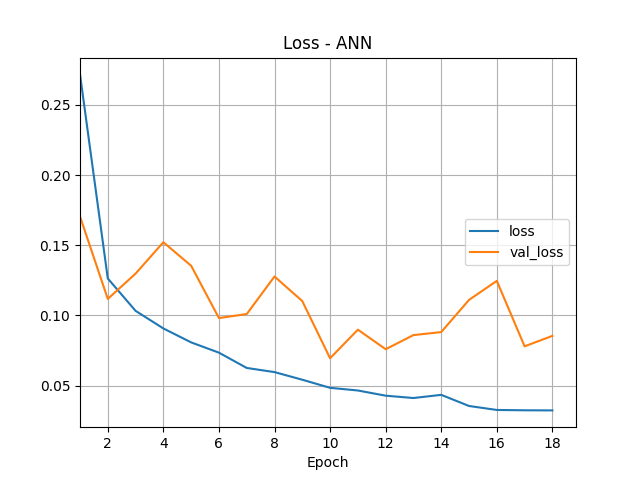

In [21]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

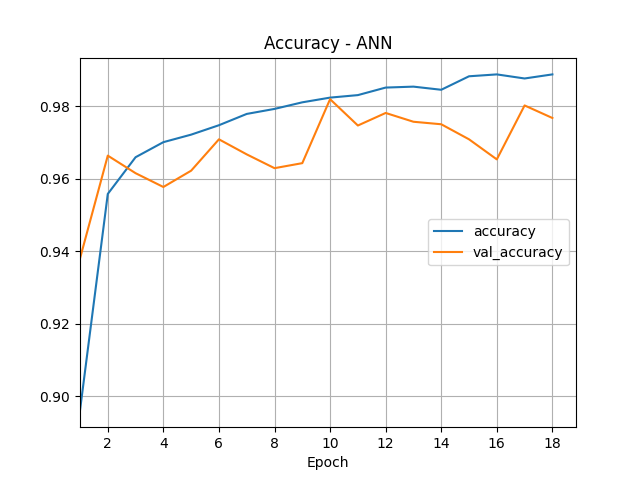

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_1 , axis=1)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

113/113 [==============================] - 0s 1ms/step
Accuracy of ANN:  0.9750830564784053


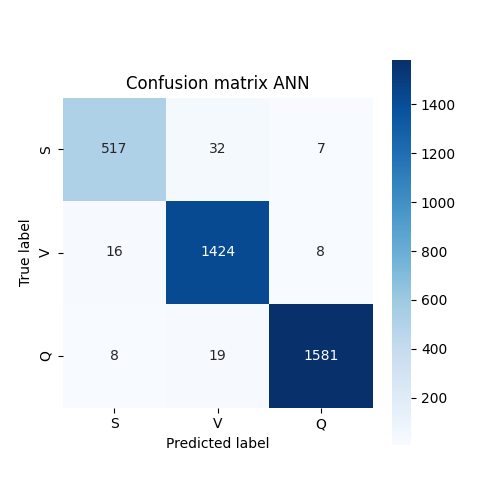

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [25]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                 Artial Premature     0.9556    0.9299    0.9426       556
Premature ventricular contraction     0.9654    0.9834    0.9743      1448
                            Paced     0.9906    0.9832    0.9869      1608

                         accuracy                         0.9751      3612
                        macro avg     0.9706    0.9655    0.9679      3612
                     weighted avg     0.9751    0.9751    0.9750      3612



### CNN

In [26]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train_nn, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid_nn))

model_cnn.load_weights('best_cnn_5.h5')
#save_model(model_cnn, 'Simple_CNN_MITBIH', 'keras')

Epoch 1/40
362/362 [==============================] - 7s 9ms/step - loss: 0.1357 - accuracy: 0.9536 - val_loss: 1.1292 - val_accuracy: 0.4822
Epoch 2/40
362/362 [==============================] - 3s 8ms/step - loss: 0.0625 - accuracy: 0.9787 - val_loss: 0.0881 - val_accuracy: 0.9688
Epoch 3/40
362/362 [==============================] - 3s 8ms/step - loss: 0.0427 - accuracy: 0.9853 - val_loss: 0.1826 - val_accuracy: 0.9470
Epoch 4/40
362/362 [==============================] - 2s 6ms/step - loss: 0.0338 - accuracy: 0.9890 - val_loss: 0.0596 - val_accuracy: 0.9806
Epoch 5/40
362/362 [==============================] - 2s 6ms/step - loss: 0.0309 - accuracy: 0.9901 - val_loss: 0.0747 - val_accuracy: 0.9761
Epoch 6/40
362/362 [==============================] - 3s 8ms/step - loss: 0.0291 - accuracy: 0.9907 - val_loss: 0.1831 - val_accuracy: 0.9488
Epoch 7/40
362/362 [==============================] - 3s 8ms/step - loss: 0.0171 - accuracy: 0.9944 - val_loss: 0.0574 - val_accuracy: 0.9858
Epoch 

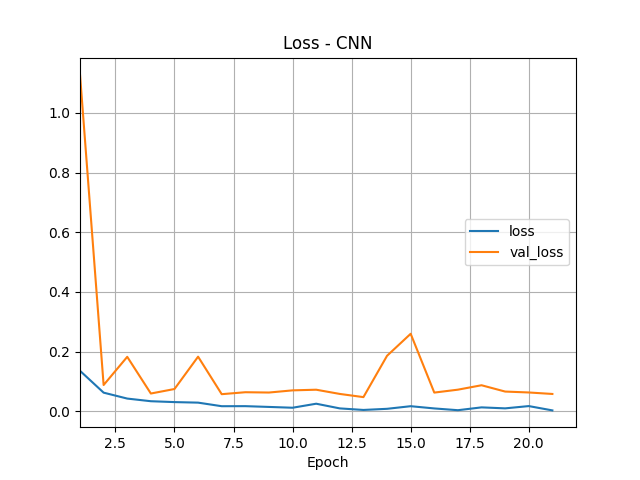

In [27]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

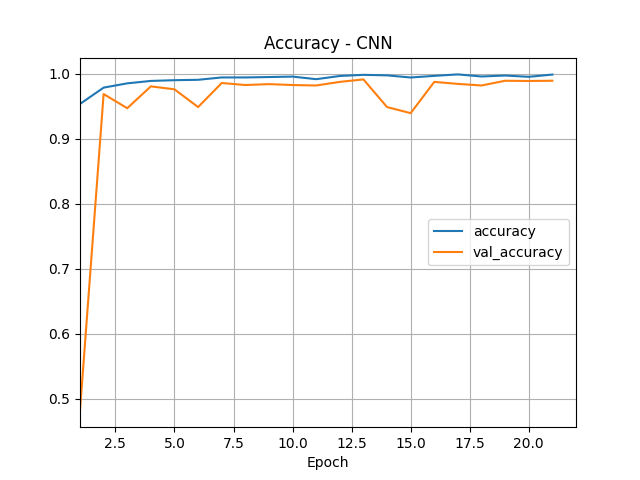

In [28]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [29]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_2 , axis=1)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

113/113 [==============================] - 0s 3ms/step
Accuracy of CNN:  0.987264673311185


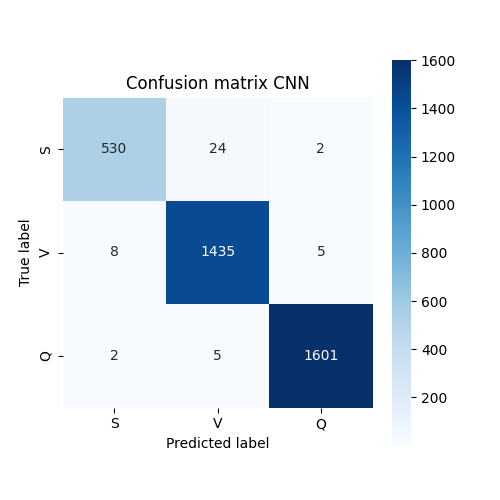

In [30]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [31]:
print(classification_report(y_test, y_pred_cnn, target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                 Artial Premature     0.9815    0.9532    0.9672       556
Premature ventricular contraction     0.9802    0.9910    0.9856      1448
                            Paced     0.9956    0.9956    0.9956      1608

                         accuracy                         0.9873      3612
                        macro avg     0.9858    0.9800    0.9828      3612
                     weighted avg     0.9873    0.9873    0.9872      3612



In [32]:
model_cnn.load_weights('best_cnn_5.h5')
save_model(model_cnn, 'CNN_MITBIH_Part_2', 'keras')